In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf

In [2]:
mpl.rcParams['figure.figsize'] = (8,8)
mpl.rcParams['axes.grid'] = False

In [3]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                    weights='imagenet')
pretrained_model.trainable = False

decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [4]:
# preprocess the image for MobileNetV2
def preprocess(img):
    img = tf.cast(img, tf.float32)
    img = img/255
    img = tf.image.resize(img, (224, 224))
    img = img[None, ...]
    return img

def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

## Predicting original image

In [27]:
# img_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
img_path = tf.keras.utils.get_file('CFdUSGyVEAAKmhh.jpg', 'https://pbs.twimg.com/media/CFdUSGyVEAAKmhh.jpg')
img_raw = tf.io.read_file(img_path)
img = tf.image.decode_image(img_raw)
img = preprocess(img)
probs = pretrained_model.predict(img)
_, img_class, class_conf = get_imagenet_label(probs)

print(img_class, class_conf)

tabby 0.17750691


## Display image

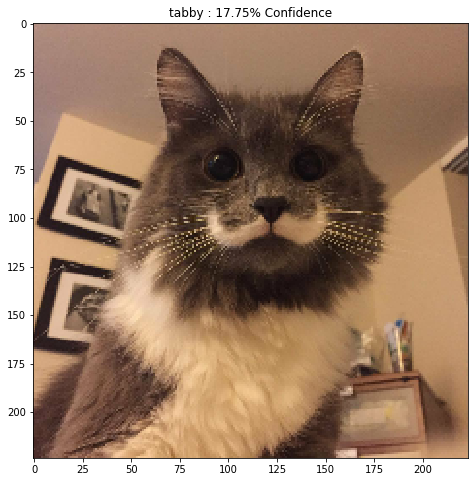

In [28]:
plt.figure()
plt.imshow(img[0])
plt.title('{} : {:.2f}% Confidence'.format(img_class, class_conf*100))
plt.show()

In [29]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

In [30]:
def create_adversarial_pertubation(input_img, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_img)
        pred = pretrained_model(input_img)
        loss = loss_object(input_label, pred)
    
    gradient = tape.gradient(loss, input_img)
    signed_grad = tf.sign(gradient)
    return signed_grad

In [31]:
print(probs.shape)

(1, 1000)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3)


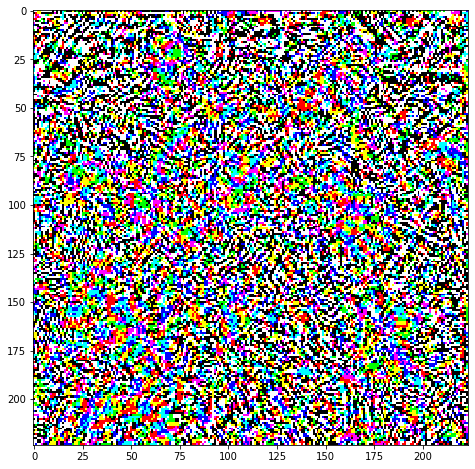

In [32]:
pertubations = create_adversarial_pertubation(img, probs)
plt.imshow(pertubations[0])
print(pertubations.shape)

In [33]:
def display_img(img, desc):
    _, label, probs = get_imagenet_label(pretrained_model.predict(img))
    plt.figure()
    plt.imshow(img[0])
    plt.title('{}\n{} : {:.2f}% confidence'.format(desc, label, probs*100))
    plt.show()

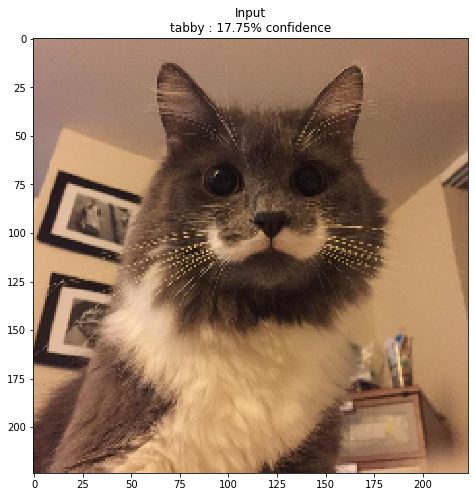

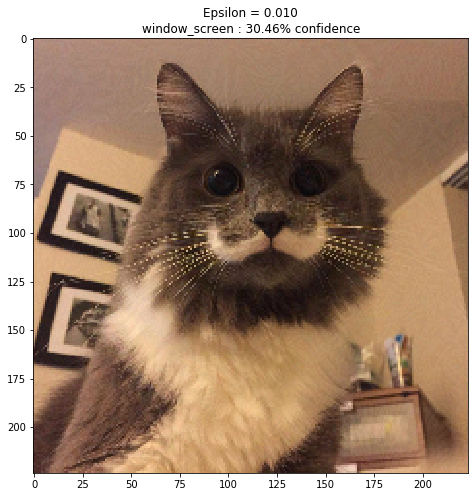

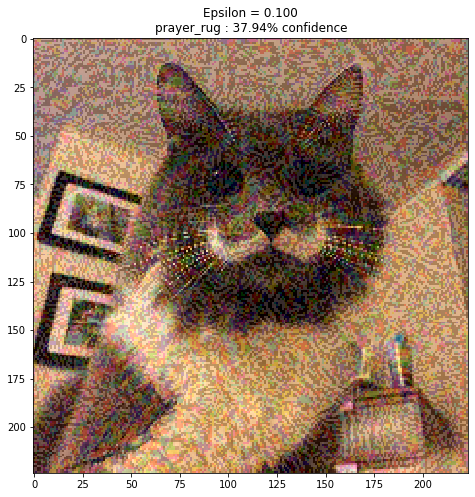

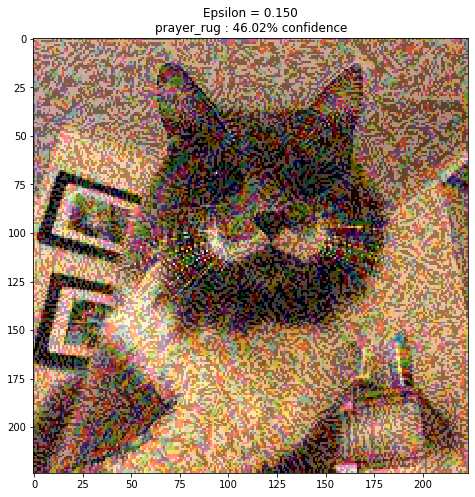

In [34]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:.3f}'.format(eps) if eps else 'Input') for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = img + eps*pertubations
    adv_x = tf.clip_by_value(adv_x, 0, 1)
    display_img(adv_x, descriptions[i])